In [1]:
# Import Required Libraries
import os
import shutil
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# !unzip -qq archive.zip

2024-01-08 02:56:40.873013: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 02:56:40.875560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 02:56:40.923263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 02:56:40.924031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 02:56:41.755804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Check Tensorflow Version
import tensorflow
tensorflow.__version__

'2.13.1'

# Exploratory Data Analysis(EDA)

In [3]:
base_dir = './'
tumorous_imgs = [fn for fn in os.listdir(f'{base_dir}/yes') if fn.endswith('.jpg')]
non_tumorous_imgs = [fn for fn in os.listdir(f'{base_dir}/no') if fn.endswith('.jpg')]

num_tumorous_imgs = len(tumorous_imgs)
num_non_tumorous_imgs = len(non_tumorous_imgs)

len(non_tumorous_imgs), len(tumorous_imgs)

(1500, 1500)

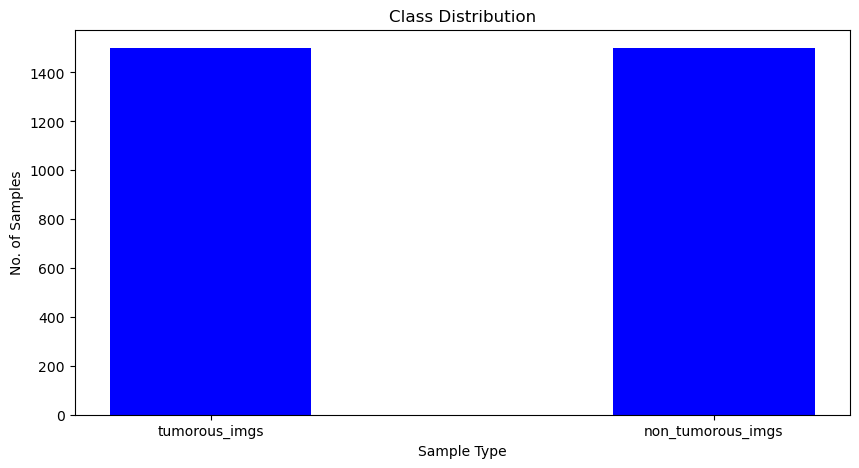

In [4]:
data = {'tumorous_imgs':len(tumorous_imgs), 'non_tumorous_imgs':len(non_tumorous_imgs)}
Samples = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Samples, values, color ='blue', 
        width = 0.4)
 
plt.xlabel("Sample Type")
plt.ylabel("No. of Samples")
plt.title("Class Distribution")
plt.show()

<b> The classes are balanced, hence acccuracy is an appropriate metric for evaluating the performance. Let us inspect the MRI images next. </b>

In [5]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        #index=np.argmax(labels[i])
        #class_name=classes[index]
        if labels[i] == 1:
            class_name= "Tumorous"
        elif labels[i] ==0:
            class_name= "Non-Tumorous"
        else:
            class_name= "Indeterminate"
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [6]:
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

IMG_PATH = "./"

# split the data by train/val/test
# ignored = {"pred","Br35H-Mask-RCNN"}
accepted = {"no", "yes"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS in accepted:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 0.20*IMG_NUM:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.80*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists


In [7]:
# Set up paths to training, validation and test data
train_dir = './TRAIN'
val_dir = './VAL'
test_dir = './TEST'

In [8]:
# Initialize Model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2024-01-08 02:56:44.061382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 02:56:44.096621: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# Compile Model
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [10]:
# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [12]:
# Validation Data Generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [13]:
# Test Data Generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


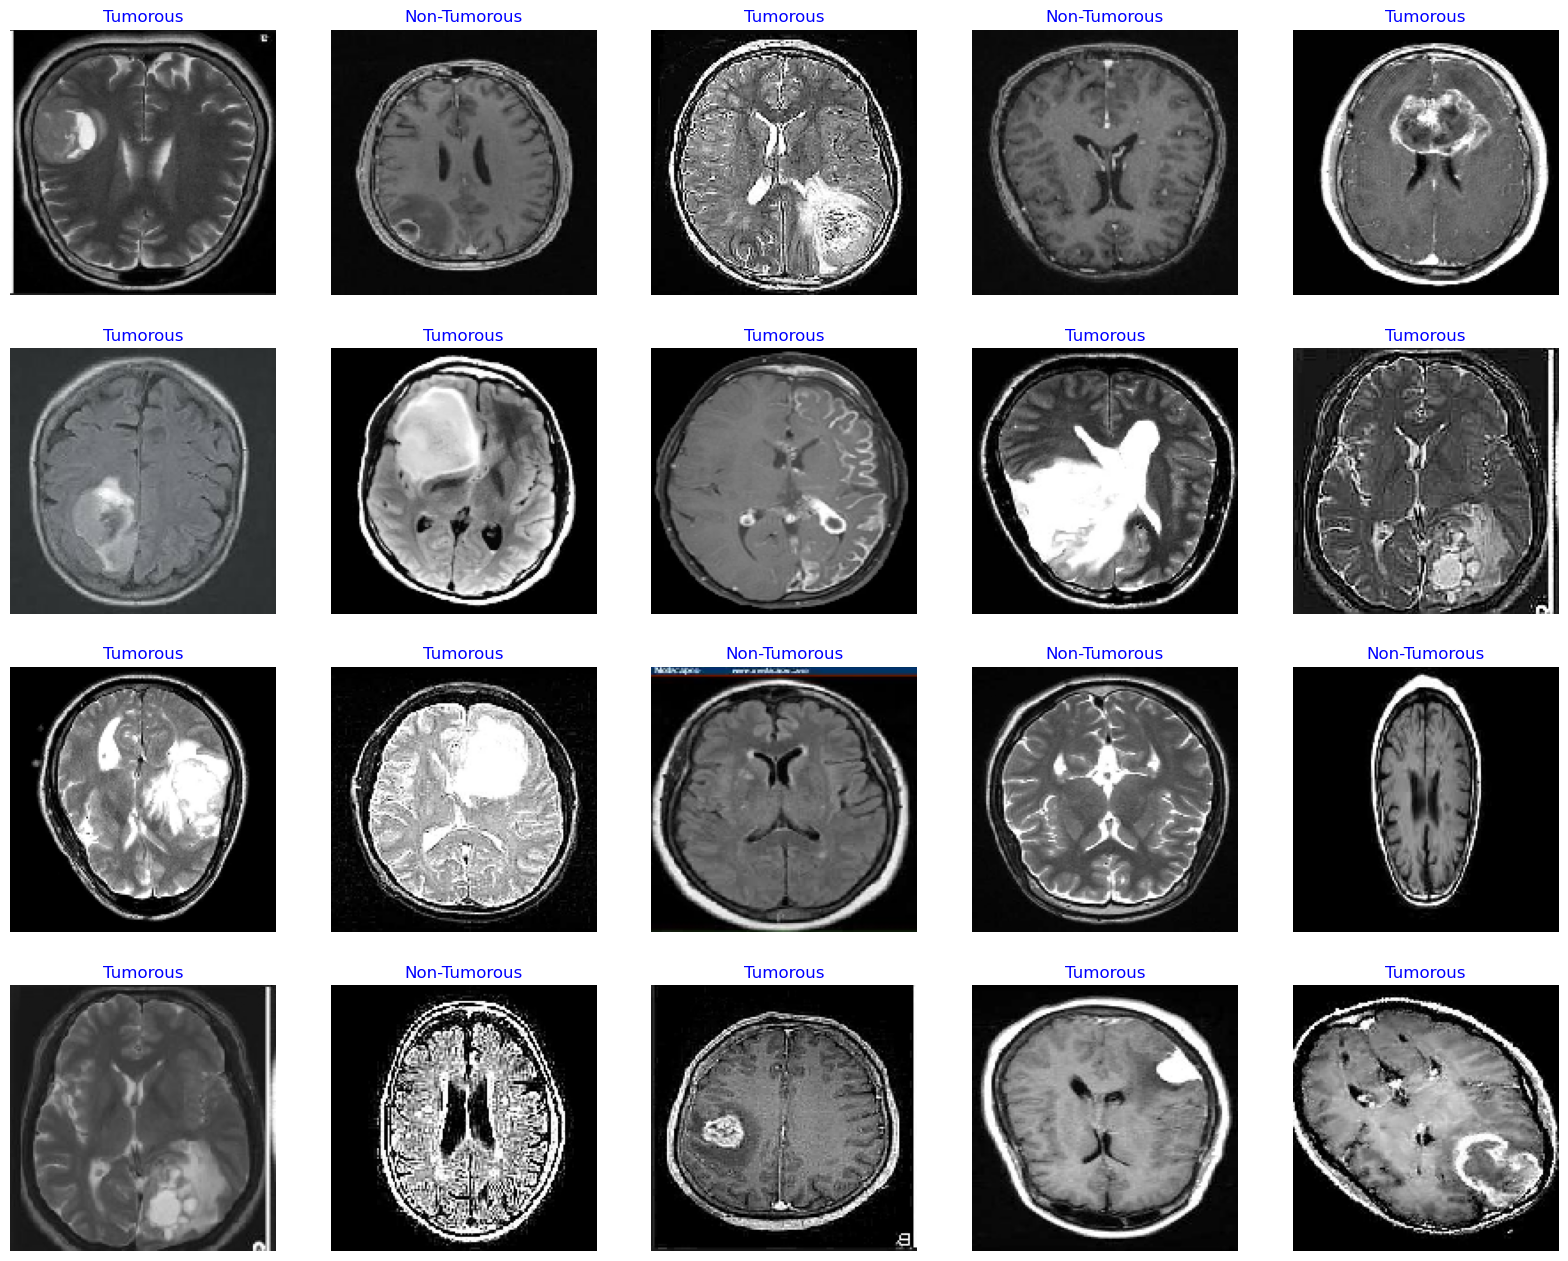

In [14]:
show_image_samples(train_generator)

In [15]:
# Inspect Data & Labels Batch Shape
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [16]:
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_original_data.tf",
        save_best_only=True,
        monitor="val_loss",
        save_format="tf")
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.5106 - acc: 0.7456INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 9s 93ms/step - loss: 0.5106 - acc: 0.7456 - val_loss: 0.4581 - val_acc: 0.7950
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.3904 - acc: 0.8311INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.3904 - acc: 0.8311 - val_loss: 0.3627 - val_acc: 0.8300
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.3371 - acc: 0.8572INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.3371 - acc: 0.8572 - val_loss: 0.3259 - val_acc: 0.8733
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: 0.2470 - acc: 0.9089INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.2470 - acc: 0.9089 - val_loss: 0.3091 - val_acc: 0.8650
Epoch 5/30
90/90 [==============================] - ETA: 0s - loss: 0.1991 - acc: 0.9344INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.1991 - acc: 0.9344 - val_loss: 0.2262 - val_acc: 0.9183
Epoch 6/30
90/90 [==============================] - ETA: 0s - loss: 0.1591 - acc: 0.9550INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.1591 - acc: 0.9550 - val_loss: 0.1965 - val_acc: 0.9383
Epoch 7/30
90/90 [==============================] - 7s 82ms/step - loss: 0.1270 - acc: 0.9672 - val_loss: 0.1972 - val_acc: 0.9350
Epoch 8/30
90/90 [==============================] - ETA: 0s - loss: 0.0960 - acc: 0.9772INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 92ms/step - loss: 0.0960 - acc: 0.9772 - val_loss: 0.1581 - val_acc: 0.9517
Epoch 9/30
90/90 [==============================] - ETA: 0s - loss: 0.0709 - acc: 0.9833INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 89ms/step - loss: 0.0709 - acc: 0.9833 - val_loss: 0.1464 - val_acc: 0.9533
Epoch 10/30
90/90 [==============================] - ETA: 0s - loss: 0.0594 - acc: 0.9906INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.0594 - acc: 0.9906 - val_loss: 0.1324 - val_acc: 0.9583
Epoch 11/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0456 - acc: 0.9939 - val_loss: 0.1354 - val_acc: 0.9550
Epoch 12/30
90/90 [==============================] - ETA: 0s - loss: 0.0394 - acc: 0.9950INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0394 - acc: 0.9950 - val_loss: 0.1222 - val_acc: 0.9567
Epoch 13/30
90/90 [==============================] - ETA: 0s - loss: 0.0330 - acc: 0.9961INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0330 - acc: 0.9961 - val_loss: 0.1174 - val_acc: 0.9583
Epoch 14/30
90/90 [==============================] - 7s 82ms/step - loss: 0.0311 - acc: 0.9972 - val_loss: 0.1294 - val_acc: 0.9550
Epoch 15/30
90/90 [==============================] - ETA: 0s - loss: 0.0227 - acc: 0.9994INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0227 - acc: 0.9994 - val_loss: 0.1122 - val_acc: 0.9600
Epoch 16/30
90/90 [==============================] - ETA: 0s - loss: 0.0177 - acc: 0.9989INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0177 - acc: 0.9989 - val_loss: 0.1095 - val_acc: 0.9600
Epoch 17/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0191 - acc: 0.9978 - val_loss: 0.1579 - val_acc: 0.9533
Epoch 18/30
90/90 [==============================] - 7s 82ms/step - loss: 0.0133 - acc: 0.9994 - val_loss: 0.1779 - val_acc: 0.9450
Epoch 19/30
90/90 [==============================] - 8s 84ms/step - loss: 0.0122 - acc: 0.9994 - val_loss: 0.1131 - val_acc: 0.9617
Epoch 20/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.1222 - val_acc: 0.9600
Epoch 21/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9633
Epoch 22/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.1186 - val_acc: 0.9667
Epoch 23/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0064 - acc: 

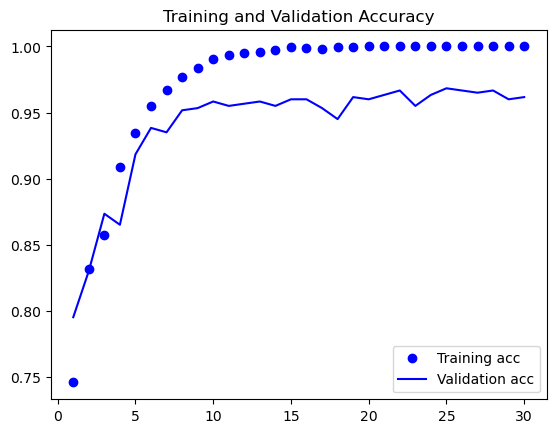

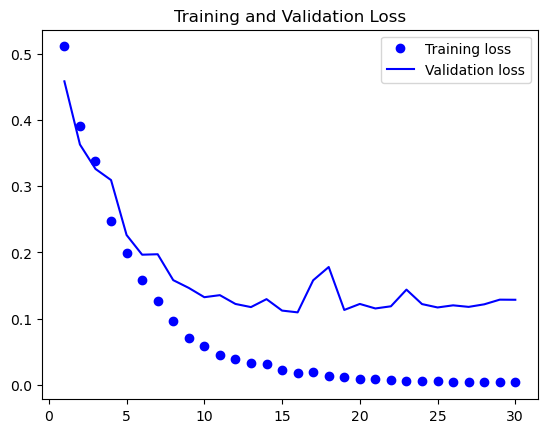

In [17]:
# Plot loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
# Compute Median Training Accuracy
acc_median = np.median(acc)
acc_median

0.9983333349227905

# Data Augmentation

In [19]:
# Initialize Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       
    width_shift_range=0.1,                               
    height_shift_range=0.1, 
    shear_range=0.1, 
    brightness_range=(0.3, 1.0),                 
    horizontal_flip=True,                             
    vertical_flip=True,
    fill_mode='nearest')

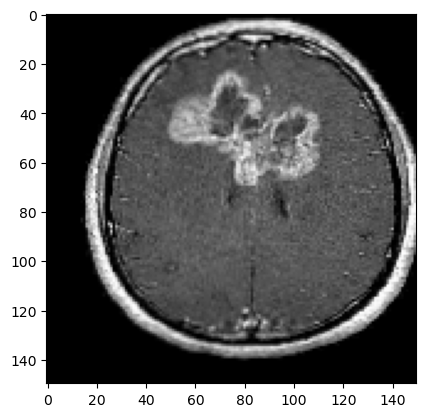

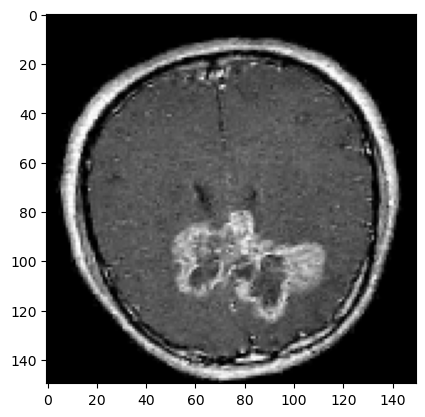

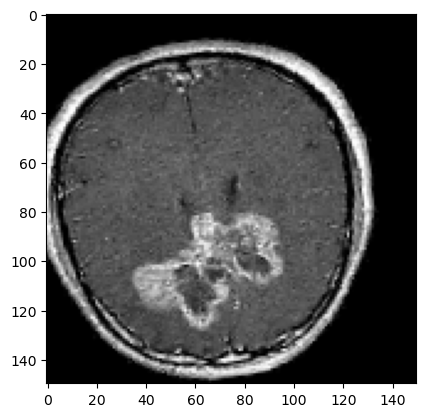

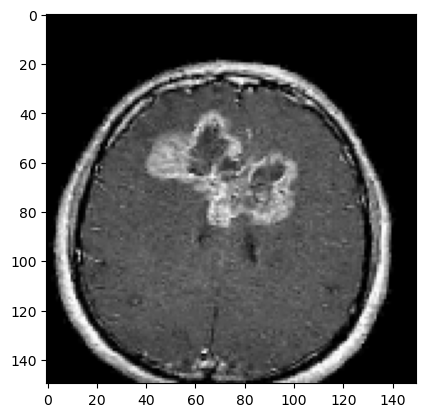

In [20]:
# Plot Input Images
fnames = [os.path.join(train_dir+"/YES", fname) for
    fname in os.listdir(train_dir+"/YES")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [21]:
# Training Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       
    width_shift_range=0.1,                               
    height_shift_range=0.1, 
    shear_range=0.1, 
    brightness_range=(0.3, 1.0),                 
    horizontal_flip=True,                             
    vertical_flip=True,
    fill_mode='nearest')

In [22]:
# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Initialize Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [24]:
# Initialize Validation Data Generator
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 600 images belonging to 2 classes.


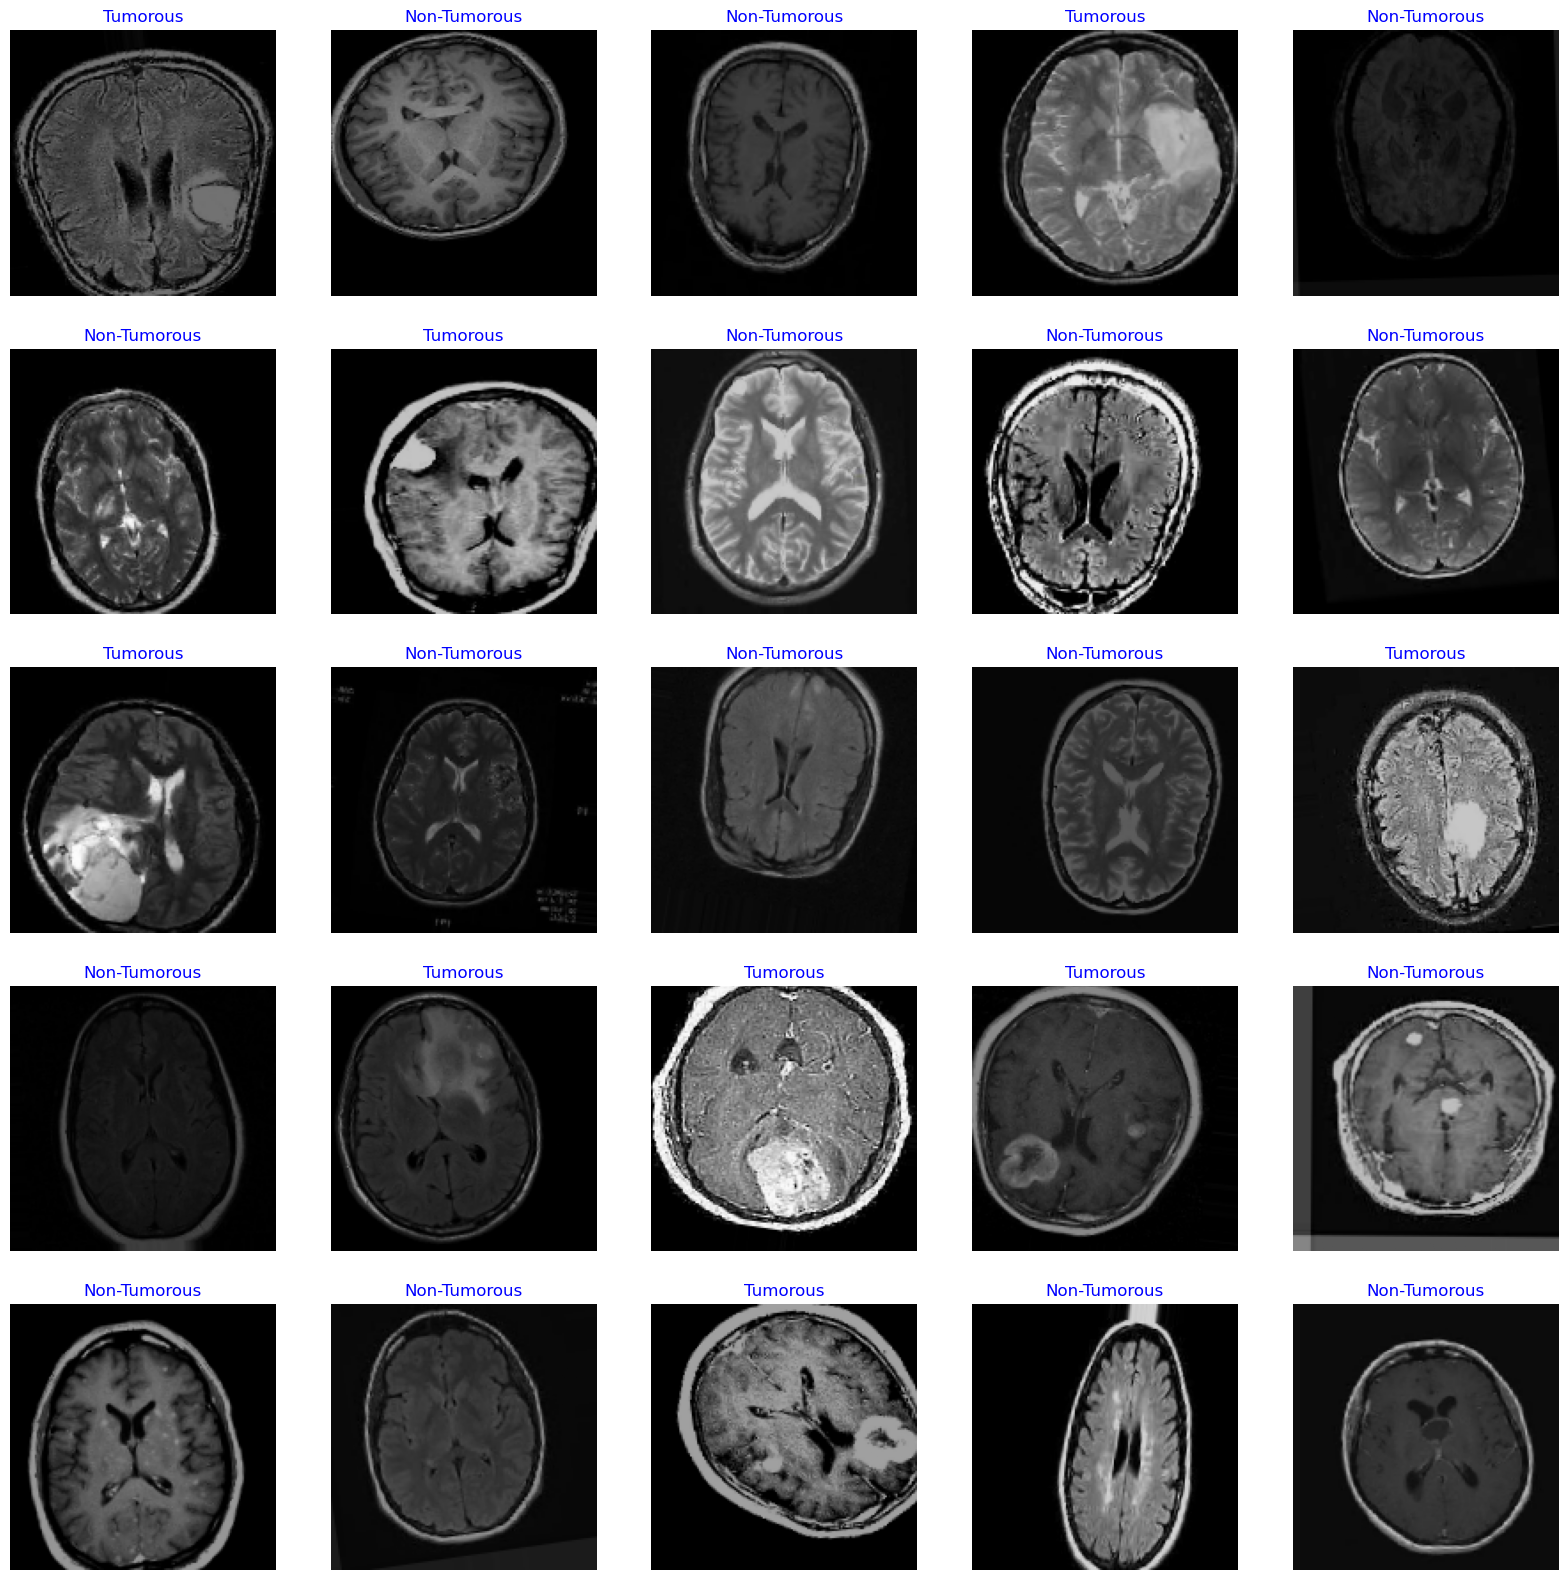

In [25]:
show_image_samples(train_generator)

In [ ]:
# Train Model With Augmented Data
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_augmented_data.tf",
        save_best_only=True,
        monitor="val_loss",
        save_format="tf")
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9544INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


57/57 [==============================] - 57s 1s/step - loss: 0.1157 - accuracy: 0.9544 - val_loss: 0.1492 - val_accuracy: 0.9583
Epoch 2/30
57/57 [==============================] - 46s 798ms/step - loss: 0.0992 - accuracy: 0.9622 - val_loss: 0.1512 - val_accuracy: 0.9367
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9628INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


57/57 [==============================] - 56s 984ms/step - loss: 0.0881 - accuracy: 0.9628 - val_loss: 0.1042 - val_accuracy: 0.9617
Epoch 4/30
57/57 [==============================] - 45s 788ms/step - loss: 0.0913 - accuracy: 0.9650 - val_loss: 0.1091 - val_accuracy: 0.9633
Epoch 5/30
57/57 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9611INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


57/57 [==============================] - 56s 978ms/step - loss: 0.0985 - accuracy: 0.9611 - val_loss: 0.0851 - val_accuracy: 0.9717
Epoch 6/30
57/57 [==============================] - 45s 787ms/step - loss: 0.0793 - accuracy: 0.9650 - val_loss: 0.1478 - val_accuracy: 0.9550
Epoch 7/30
57/57 [==============================] - 45s 792ms/step - loss: 0.0903 - accuracy: 0.9694 - val_loss: 0.0965 - val_accuracy: 0.9683
Epoch 8/30
57/57 [==============================] - 47s 818ms/step - loss: 0.0668 - accuracy: 0.9767 - val_loss: 0.0966 - val_accuracy: 0.9733
Epoch 9/30
57/57 [==============================] - 46s 813ms/step - loss: 0.0819 - accuracy: 0.9656 - val_loss: 0.1063 - val_accuracy: 0.9700
Epoch 10/30
57/57 [==============================] - 47s 823ms/step - loss: 0.0697 - accuracy: 0.9717 - val_loss: 0.0970 - val_accuracy: 0.9717
Epoch 11/30
57/57 [==============================] - 51s 898ms/step - loss: 0.0628 - accuracy: 0.9761 - val_loss: 0.1167 - val_accuracy: 0.9600
Epoch 12

In [ ]:
# Inspect Accuracy and Loss
acc_aug = history.history['acc']
val_acc_aug = history.history['val_acc']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_original_data.tf")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_augmented_data.tf")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

<b> We see that data augmentation has not led to improved performance, possibly because the images we generated were in some cases not representative and/or made the tumor harder to detect.</b>

In [26]:
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


def make_model_Xception(learning_rate, droprate, input_shape, inner_layer):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dropout = keras.layers.Dropout(droprate)(dense)
    outputs = keras.layers.Dense(1, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [27]:
model = make_model_Xception(learning_rate=0.01, droprate=0.0, input_shape=150, inner_layer=25)
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
57/57 [==============================] - 55s 917ms/step - loss: 0.3725 - accuracy: 0.8461 - val_loss: 0.2535 - val_accuracy: 0.8867
Epoch 2/30
57/57 [==============================] - 51s 899ms/step - loss: 0.2194 - accuracy: 0.9144 - val_loss: 0.1883 - val_accuracy: 0.9267
Epoch 3/30
57/57 [==============================] - 52s 905ms/step - loss: 0.1695 - accuracy: 0.9344 - val_loss: 0.1855 - val_accuracy: 0.9300
Epoch 4/30
57/57 [==============================] - 51s 897ms/step - loss: 0.1437 - accuracy: 0.9383 - val_loss: 0.1493 - val_accuracy: 0.9467
Epoch 5/30
57/57 [==============================] - 51s 900ms/step - loss: 0.1621 - accuracy: 0.9389 - val_loss: 0.1355 - val_accuracy: 0.9517
Epoch 6/30
57/57 [==============================] - 51s 901ms/step - loss: 0.1249 - accuracy: 0.9500 - val_loss: 0.1374 - val_accuracy: 0.9433
Epoch 7/30
57/57 [==============================] - 51s 900ms/step - loss: 0.1177 - accuracy: 0.9539 - val_loss: 0.1258 - val_accuracy: 0.9550

In [28]:
test_model = model
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy with Xception: {test_acc:.3f}")

30/30 [==============================] - 12s 400ms/step - loss: 0.1222 - accuracy: 0.9550
Test accuracy with Xception: 0.955


In [29]:
from tensorflow.keras.applications.vgg16 import VGG16


def make_model_VGG16(learning_rate, droprate, input_shape, inner_layer):
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense1 = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dense2 = keras.layers.Dense(int(inner_layer*0.5), activation='relu')(dense1)
    dense3 = keras.layers.Dense(int(inner_layer*0.15), activation='relu')(dense2)
    dropout = keras.layers.Dropout(droprate)(dense3)
    outputs = keras.layers.Dense(1, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [30]:
model2 = make_model_VGG16(learning_rate=0.01, droprate=0.0, input_shape=150, inner_layer=25)
history = model2.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
57/57 [==============================] - 124s 2s/step - loss: 0.7012 - accuracy: 0.5050 - val_loss: 0.6903 - val_accuracy: 0.5067
Epoch 2/30
57/57 [==============================] - 123s 2s/step - loss: 0.6840 - accuracy: 0.5028 - val_loss: 0.6840 - val_accuracy: 0.5450
Epoch 3/30
57/57 [==============================] - 122s 2s/step - loss: 0.6794 - accuracy: 0.5039 - val_loss: 0.6834 - val_accuracy: 0.6217
Epoch 4/30
57/57 [==============================] - 122s 2s/step - loss: 0.6749 - accuracy: 0.5061 - val_loss: 0.6631 - val_accuracy: 0.5283
Epoch 5/30
57/57 [==============================] - 122s 2s/step - loss: 0.6665 - accuracy: 0.5167 - val_loss: 0.6530 - val_accuracy: 0.5717
Epoch 6/30
57/57 [==============================] - 122s 2s/step - loss: 0.6587 - accuracy: 0.5306 - val_loss: 0.6424 - val_accuracy: 0.5783
Epoch 7/30
57/57 [==============================] - 118s 2s/step - loss: 0.6517 - accuracy: 0.5428 - val_loss: 0.6437 - val_accuracy: 0.7567
Epoch 8/30
57

In [31]:
test_model = model2
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 27s 910ms/step - loss: 0.4203 - accuracy: 0.8417
Test accuracy: 0.842


We see that Xception has a much better accuracy on test data (0.93) than VGG16 (0.84), so we will now experiment with parameter tuning for Xception.

# Hyperparameter Tuning for Xception

In [32]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model_Xception(learning_rate=lr, droprate=0.0, input_shape=150, inner_layer=25)
    print(lr)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator, batch_size=32)
    scores[lr] = history.history
    print()
    print()

0.0001
Epoch 1/10
57/57 [==============================] - 50s 825ms/step - loss: 0.5570 - accuracy: 0.6906 - val_loss: 0.4428 - val_accuracy: 0.8033
Epoch 2/10
57/57 [==============================] - 50s 871ms/step - loss: 0.4023 - accuracy: 0.8144 - val_loss: 0.3474 - val_accuracy: 0.8500
Epoch 3/10
57/57 [==============================] - 51s 897ms/step - loss: 0.3395 - accuracy: 0.8467 - val_loss: 0.3003 - val_accuracy: 0.8750
Epoch 4/10
57/57 [==============================] - 51s 899ms/step - loss: 0.3036 - accuracy: 0.8800 - val_loss: 0.2689 - val_accuracy: 0.8833
Epoch 5/10
57/57 [==============================] - 51s 910ms/step - loss: 0.2629 - accuracy: 0.9022 - val_loss: 0.2436 - val_accuracy: 0.9050
Epoch 6/10
57/57 [==============================] - 52s 902ms/step - loss: 0.2473 - accuracy: 0.9044 - val_loss: 0.2285 - val_accuracy: 0.9067
Epoch 7/10
57/57 [==============================] - 51s 897ms/step - loss: 0.2332 - accuracy: 0.9067 - val_loss: 0.2148 - val_accuracy:

([<matplotlib.axis.XTick at 0x7f8f4899ead0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

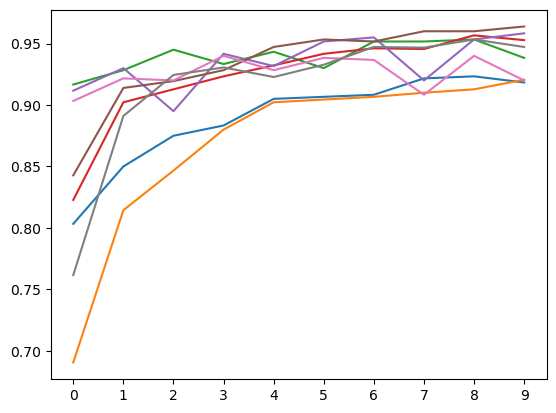

In [33]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %lr))
    plt.plot(hist['accuracy'], label=('train=%s' %lr))
plt.xticks(np.arange(10))

In [35]:
scores = {}
learning_rate = 0.01

for size in [10, 25, 100]:
    print(size)
    model = make_model_Xception(learning_rate=learning_rate, droprate=0.0, input_shape=150, inner_layer=size)
    print(size)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
    scores[size] = history.history
    print()
    print()

10
10
Epoch 1/10
57/57 [==============================] - 55s 932ms/step - loss: 0.4321 - accuracy: 0.8122 - val_loss: 0.2318 - val_accuracy: 0.8983
Epoch 2/10
57/57 [==============================] - 51s 898ms/step - loss: 0.2494 - accuracy: 0.8972 - val_loss: 0.3165 - val_accuracy: 0.8983
Epoch 3/10
57/57 [==============================] - 51s 896ms/step - loss: 0.2091 - accuracy: 0.9117 - val_loss: 0.1706 - val_accuracy: 0.9183
Epoch 4/10
57/57 [==============================] - 51s 897ms/step - loss: 0.1648 - accuracy: 0.9417 - val_loss: 0.1960 - val_accuracy: 0.9400
Epoch 5/10
57/57 [==============================] - 51s 893ms/step - loss: 0.1450 - accuracy: 0.9467 - val_loss: 0.1554 - val_accuracy: 0.9450
Epoch 6/10
57/57 [==============================] - 52s 918ms/step - loss: 0.1302 - accuracy: 0.9517 - val_loss: 0.2030 - val_accuracy: 0.9283
Epoch 7/10
57/57 [==============================] - 51s 897ms/step - loss: 0.1508 - accuracy: 0.9372 - val_loss: 0.1229 - val_accuracy: 

([<matplotlib.axis.XTick at 0x7f8ec15cef10>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

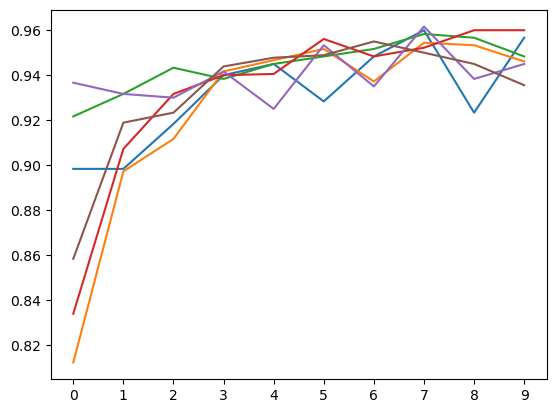

In [36]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %size))
    plt.plot(hist['accuracy'], label=('train=%s' %size))
plt.xticks(np.arange(10))

In [37]:
import tensorflow as tf
Loaded_Model = tf.keras.models.load_model('convnet_from_scratch_original_data.tf')

In [38]:
tf.keras.models.save_model(Loaded_Model, 'convnet_from_scratch_original_data.h5') # Saving the Model in H5 Format

/tmp/ipykernel_16207/3237619043.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(Loaded_Model, 'convnet_from_scratch_original_data.h5') # Saving the Model in H5 Format


In [39]:
Loaded_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________

<b> Since using Xception or VGG16 does not improve upon the performance of the simpler convolutional neural net (CNN), we will save the CNN and use that for deployment. </b>